In [ ]:
from cryosparc.tools import CryoSPARC
import json
import numpy as np
import matplotlib.pyplot as plt
with open('/u/rposert/instance-info.json', 'r') as f:
    instance_info = json.load(f)

In [2]:
cs = CryoSPARC(**instance_info)
assert cs.test_connection()
project_id = "P297"
workspace_id = "W1"
job_id = "J45"

project = cs.find_project(project_id)
flex_train = project.find_job(job_id)
particles = flex_train.load_output('particles')

Connection succeeded to CryoSPARC command_core at http://cryoem0.sbi:40002
Connection succeeded to CryoSPARC command_vis at http://cryoem0.sbi:40003
Connection succeeded to CryoSPARC command_rtp at http://cryoem0.sbi:40005


Text(0.5, 1.0, 'Before filtering')

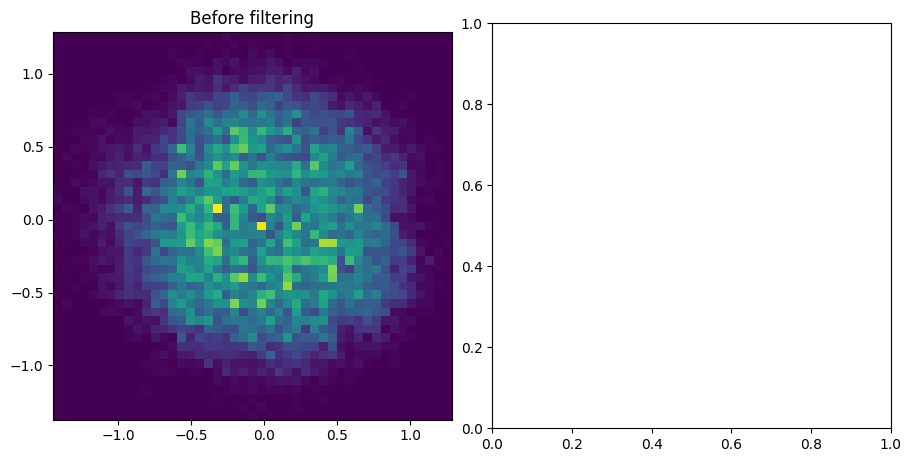

In [32]:
# for this example, we'll just filter particles which are near the center
# of the latent space, but you could do whatever you want
fig, axs = plt.subplots(1, 2, layout = "constrained", figsize = (9, 4.5))
hist, xedges, yedges, im = axs[0].hist2d(
    particles["components_mode_0/value"],
    particles["components_mode_1/value"],
    bins = 45
)
axs[0].set_aspect("equal")
_ = axs[0].set_xlim(min(xedges), max(xedges))
_ = axs[0].set_ylim(min(yedges), max(yedges))
axs[0].set_title("Before filtering")

In [10]:
# the filter function takes in a row (a single particle) and tells us whether we should keep it.
# there are faster ways to do this, but this is the easiest for a general audience. Please check
# the cryosparc-tools Dataset documentation for more filtering methods if this is too slow

def filter_function(row) -> bool:
    conditions = [
        np.linalg.norm([row["components_mode_0/value"], row["components_mode_1/value"]]) < 0.5,
    ]
    return all(conditions)

mask = [filter_function(row) for row in particles.rows()]
filtered_dataset = particles.mask(mask)

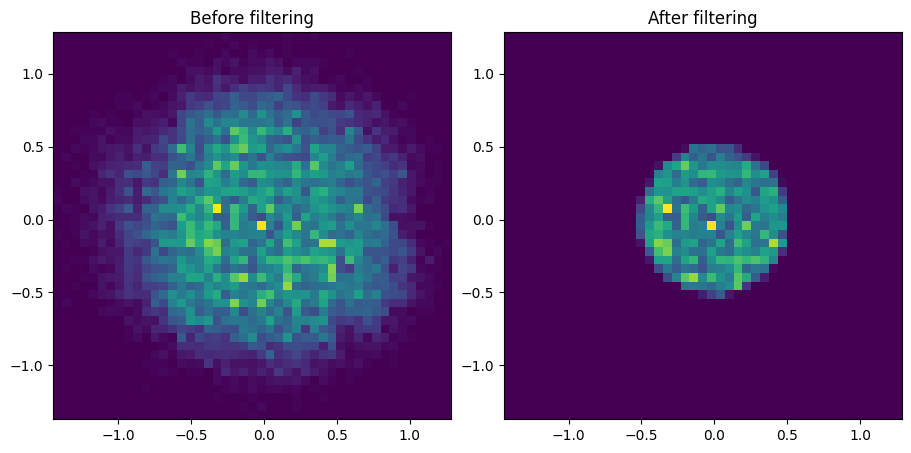

In [33]:
axs[1].hist2d(
    filtered_dataset["components_mode_0/value"],
    filtered_dataset["components_mode_1/value"],
    bins = 45,
    range = [
        [min(xedges), max(xedges)],
        [min(yedges), max(yedges)]
    ]
)

axs[1].set_aspect("equal")
_ = axs[1].set_xlim(min(xedges), max(xedges))
_ = axs[1].set_ylim(min(yedges), max(yedges))
axs[1].set_title("After filtering")
fig

In [35]:
ext_job_uid = project.save_external_result(
    workspace_uid=workspace_id,
    dataset=filtered_dataset,
    type="particle",
    slots=['blob'],
    passthrough=(job_id, "particles"),
    title="Filtered particle set by latent coordinates"
)
project.find_external_job(ext_job_uid).log_plot(fig, "Filtering result")

'6753284f624dc71e22c2eb7e'